## DGANs using mnist dataset
> - A documented Implementation for the DCGAN paper: [`Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks`](https://arxiv.org/abs/1511.06434)
> - For model training run the [train.py](./train.py)  file.

### Roadmap
1. [x] build the generator 
1. [x] build the dicreminator
1. [x] build the combined model
1. [x] build a visualization strategy for visualizing the output

## 1. Loading the data and preprocessing it

### 1.1 Loading the dataset

In [1]:
from tensorflow import keras

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D, UpSampling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import adam_v2

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# getting only the training dataset as that the only data we care about
(training_data, _), (_, _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
training_data.shape

(60000, 28, 28)

### 1.2. __Visualizing some samples__             
__1.2.1. Annotating an Image with it's pixel values__

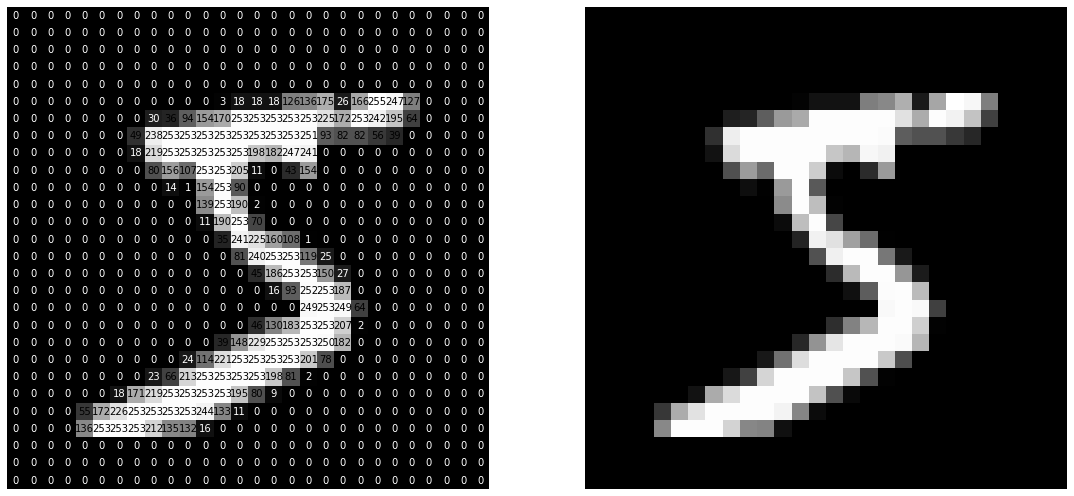

In [6]:
def visualize_input(img, ax):
  ax.imshow(img, cmap='gray')
  width, height = img.shape
  thresh = img.max() / 8

  #looping over every pixel annotate it with its value
  for x in range(width):
    for y in range(height):
      ax.set_axis_off()
      ax.annotate(str(round(img[x][y])), xy=(y, x),
                  horizontalalignment='center',
                  verticalalignment='center',
                  color='white' if img[x][y] < thresh else 'black')

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (19, 10)) #you can assign any arguments for the figure from here

visualize_input(training_data[0], ax0)

ax1.set_axis_off()
ax1.imshow(training_data[0], cmap='gray')

fig.savefig('/content/image_annotated_with_pixel_values.png')
plt.show()

__1.2.2. Displaying a random picked set of images from the dataset__

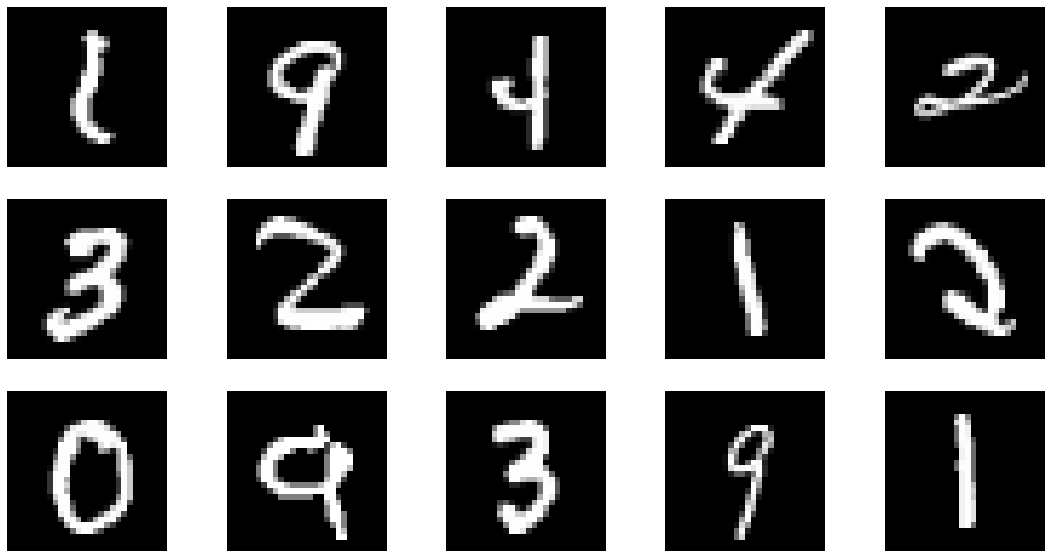

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize = (19, 10))

for row in range(3):
  for col in range(5):
  # picking an int between 0, number of examples in the training data
    img_idx = np.random.randint(1, 60000)

    # plt.axis('off')
    axes[row][col].set_axis_off()
    axes[row][col].imshow(training_data[img_idx], cmap='gray')
    
fig.savefig('/content/fashion_mnist_figure.png')
plt.show()

### Edit this please 1.3 __Standarizing the dataset with a mean of zero and std of one__

In [8]:
training_data = training_data / 127.5 - 1.
training_data = np.expand_dims(training_data, 3)


__Now the values have a _`mean = 0`_ and _`std = 1`___

## 2. Building DCGAN

### 2.1 Creating the generator
 __input__(random noise as a vector `z`) -> reshape -> upsample -> getting an image

In [9]:
def build_generator():
  generator = Sequential()

  # the first dense layer
  generator.add(Dense(128 * 7 * 7, activation='relu', input_dim=100))

  #reshaping the first dense layer to feed it into convnet
  generator.add(Reshape((7, 7, 128)))

  # upsampling layer that will makes the dims to 14*14*128
  generator.add(UpSampling2D()) # defaults to 2*2 wich double the shape

  # conv(128) -> BN -> upsampling
  generator.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
  generator.add(BatchNormalization(momentum=0.8))
  
  # conv(128) -> BN -> upsampling
  generator.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
  generator.add(BatchNormalization(momentum=0.8))

  generator.add(UpSampling2D()) # getting the actual dim of the image 28*28

  # conv(64) -> BN
  generator.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
  generator.add(BatchNormalization(momentum=0.8))

  # conv(32) -> BN
  generator.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
  generator.add(BatchNormalization(momentum=0.8))

  # Resetting the depth of the Image to 1 by adding a conv layer by 1
  generator.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh'))

  generator.summary()

  noise = Input(shape=(100, ))
  fake_img = generator(noise)

  ## returns a model with input as a vector of shape 100
  ## Returns a model with outputs as an image of (28 * 28 *1)
  return Model(inputs = noise, outputs = fake_img)

### 2.2 Creating the  discriminator
__The dicriminator is a just a regular CNN takes an image binary out a real or fake__

In [10]:
def build_discriminator():
  discriminator = Sequential()

  # ---- BLOCK-1 ---- # # Conv(32) -> leaky_relu -> dropout  
  discriminator.add(Conv2D(32, kernel_size=3, strides=2, 
                           padding='same', input_shape=(28, 28, 1))) # outputs 14*14*32  
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(rate=0.25)) 


  # ---- BLOCK-2 ---- #   # Conv(64) -> zeropadding -> BN -> leaky_relu -> dropout
  discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
  # outputs 7*7*64 
  #We should add zero padding to make it 8*8*64 to be able to apply down downsampling in the next layers
  discriminator.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(rate=0.5))


  # ---- BLOCK-3 ---- # #Conv(128) -> BN -> Leaky_relu -> dropout  
  discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same')) # outputs 4*4*128 
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(rate=0.5))


  # ---- BLOCK-4 ---- # #Conv(256) -> BN -> Leaky_relu -> dropout  
  # discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding='same')) # outputs 4*4*256
  # discriminator.add(BatchNormalization(momentum=0.8))
  # discriminator.add(LeakyReLU(alpha=0.2))
  # discriminator.add(Dropout(rate=0.5))

  ## -_-_-_-_-_-_  Classifier -_-_-_-_-_-_ ##
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))

  discriminator.summary()
  
  img = Input(shape=(28, 28, 1))
  probability = discriminator(img)

  return Model(inputs=img, outputs=probability)

### 2.3 Building the combined model
__We can't train the generator by itself, we need a dicriminator with it to evaluate it.__

__So we build a combined model simply__ 
- __`input(noise) -> [Generator] -> Img -> [Discriminator] -> Fake|Real`__
- __`Input(noise) -> Combined_model -> Fake|Real`__
- __NOTE THAT, We also disabling the discriminator training in the combined model__

#### __2.3.1 Build and compile the discriminator__

In [11]:
adam = adam_v2.Adam(learning_rate=0.0001, beta_1=0.5)

discriminator = build_discriminator()

#compile it
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

__Freeze the discriminator parameters__

In [12]:
discriminator.trainable = False

#### __2.3.2 Building the combined_model__

In [13]:
generator = build_generator()

z = Input(shape=(100, ))
img = generator(z)

validity = discriminator(img) #takes a generated image and check it

combined_model = Model(inputs=z, outputs=validity)
combined_model.compile(loss='binary_crossentropy', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)      

In [14]:
combined_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         1022593   
_________________________________________________________________
model (Functional)           (None, 1)                 95489     
Total params: 1,118,082
Trainable params: 1,021,889
Non-trainable params: 96,193
_________________________________________________________________


## 3. Training the DCGAN
__As we already know that we need a custom method to train the DCGAN network as the original .fit method won't be useful here__

### 3.1 Building the Training function

In [15]:
# discriminator.trainable = True
def train(epochs, batch_size=128):
  # Manaualy creating the labels ones for the real images and zeros for the generated
  real_labels = np.ones((batch_size, 1)) #(a list of ones with a shape of (128, 1))
  gen_labels = np.zeros((batch_size, 1)) #(a list of zeros with a shape of (128, 1))

  for epoch in range(epochs):
    
    ## ---- Step-1 Train the discriminator model ---- ##
    # 1 select a random set of image from the training data
    indeces = np.random.randint(0, training_data.shape[0], batch_size) # low, high, shape
    real_imgs_batch = training_data[indeces]

    # 2 generate a batch of noise to fed it into the dicrimninator model
    noise_batch = np.random.normal(0, 1, (batch_size, 100)) # mean, std, shape
    gen_img_batch = generator.predict(noise_batch)

    # the discriminator params isn't freezed here, it's freezed in the combined model only
    
    # 1st step is to make the discriminator trainable
    discriminator.trainable = True
    disc_loss_real = discriminator.train_on_batch(real_imgs_batch, real_labels) 
    disc_loss_gen = discriminator.train_on_batch(gen_img_batch, gen_labels)
    discriminator.trainable = False

    ## ---- Training the combined model ---- ##
    # Note that the disc doesn't train here it's freezed Itonly makes predictions
    gen_loss = combined_model.train_on_batch(noise_batch, real_labels)
    # discriminator.summary()

    if epoch % 50 == 0:
      print(f"Epoch: {epoch}, Disc_loss_real: {disc_loss_real},"
            f"Disc_loss_gen: {disc_loss_gen}, Gen_loss: {gen_loss}")
    
    #plotting images every period of training
    if epoch % 200 == 0:
      plot_generated_imgs(epoch, generator)

__Defining a function for plotting a batch of images__

In [16]:
## plotting 15 imgs from using the generator
def plot_generated_imgs(epoch, generator_model):
  #generating 15 imgs
  noise_batch = np.random.normal(0, 1, (10, 100))
  gen_imgs = generator_model.predict(noise_batch)

  # gen_imgs = (gen_imgs * 127.5) + 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  # creating subplots and figures
  fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10))

  img_idx = 0
  for row in range(2):
    for col in range(5):
      axes[row][col].set_axis_off()
      axes[row][col].imshow(gen_imgs[img_idx, :,:,0], cmap='gray')
      img_idx += 1
      
  # fig.savefig('/content/fashion_mnist_figure.png')
  plt.show()

In [ ]:
train(epochs=4000, batch_size=64)

> - __Now I've gone over the implementation details for the paper.__
> - __For model training just run the the provided train.py file in the github repo:__
